# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [30]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [31]:
import sklearn
sklearn.__version__

'1.0.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [32]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y.iloc[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [33]:
def Q1():

  ### STUDENT START ###

  # The create_index function implements the blurring / filtering mechanism. 
  # The function iterates through a 28x28 grid, in order to calculate the
  # weighted average of the original value and the 8 neighboring values. 
  # The function includes a mod 28 mechanism to handle edge pixels
  # (i.e. top left, top right, etc.) in the grid. 
  def create_index(x, y, data, weight):

    x_list = []
    y_list = []

    #(x-1) (y-1)
    x_list.append((x-1)%28)
    y_list.append((y-1)%28)
    # (x-1) (y)
    x_list.append((x-1)%28)
    y_list.append(y%28)
    #(x-1) (y+1)
    x_list.append((x-1)%28)
    y_list.append((y+1)%28)
    #(x) (y-1)
    x_list.append((x)%28)
    y_list.append((y-1)%28)
    #(x)(y+1)
    x_list.append(x%28)
    y_list.append((y+1)%28)
    #(x-1)(y+1)
    x_list.append((x+1)%28)
    y_list.append((y-1)%28)
    #(x)(y+1)
    x_list.append((x+1)%28)
    y_list.append((y)%28)
    # (x+1) (y+1)
    x_list.append((x+1)%28)
    y_list.append((y+1)%28)

    # Calculates the weighted average of the center pixel of the 3x3 grid.
    average = 0.0 
    average = average + data[x][y] * weight
    
    # Calculates the weighted average of the center and 8 neighboring pixels.
    for i in range(8):
      average = average + (data[x_list[i]][y_list[i]] * weight)
    average = average / 9

    return average

  # The blur function implements the blurring / filtering mechanism. The
  # function takes in the dataset and calls the create_index function (above), 
  # in order to calculate the average pixel values required for blur. The
  # returned averages are then used to produce a model and corresponding 
  # accuracies as described in case 1 - 4 below. 
  def blur(data):

    blurred_data = []
    weight = 0.9 # Pre-defined weight that yields ~90% accuracy for most cases.

    # Iterates through the mini_train_data / dev_data datasets in order to 
    # blur / apply filter to image. 
    for i in range(data.shape[0]):
      grid = data.iloc[i].values.reshape(28, 28)
      f = np.zeros((28, 28))
      for i in range(28):
        for j in range(28):
          f[i][j] = create_index(i, j, grid, weight)
      blurred_data.append(f.flatten()) 
    
    return blurred_data 

  # Case 1: A 1-nearest-neighbors model is trained using an unfiltered
  # dataset (mini_train_data). Predictions are made on an unfiltered
  # dataset (dev_data) with accuracy score printed for analysis.
  knn_case1 = KNeighborsClassifier(n_neighbors = 1)
  knn_case1.fit(mini_train_data, mini_train_labels)
  score_case1 = knn_case1.score(dev_data, dev_labels)
  print("Case 1 Accuracy:", score_case1)

  # Case 2: A 1-nearest-neighbors model is trained using a filtered dataset 
  # (mini_train_data). Predictions are made on an unfiltered dataset (dev_data)
  # with accuracy score printed for analysis.
  blurred_data = blur(mini_train_data)
  columns = mini_train_data.columns
  new_df_train_data = pd.DataFrame(blurred_data, columns=columns)
  knn_case2 = KNeighborsClassifier(n_neighbors = 1)
  knn_case2.fit(new_df_train_data, mini_train_labels)
  score_case2 = knn_case2.score(dev_data, dev_labels)
  print("Case 2 Accuracy:", score_case2)

  # Case 3: A 1-nearest-neighbors model is trained using an unfiltered dataset
  # (mini_train_data). Predictions are made on a filtered dataset (dev_data)
  # with accuracy score printed for analysis. 
  blurred_dev_data = blur(dev_data)
  columns = dev_data.columns
  new_df_dev_data = pd.DataFrame(blurred_dev_data, columns=columns)
  knn_case3 = KNeighborsClassifier(n_neighbors = 1)
  knn_case3.fit(mini_train_data, mini_train_labels)
  score_case3 = knn_case3.score(new_df_dev_data, dev_labels)
  print("Case 3 Accuracy:", score_case3)

  # Case 4: A 1-nearest neighbors model is trained using a filtered dataset
  # (mini_train_data). Predictions are made on a filtered dataset (dev_data)
  # with accuracy scores printed for analysis. 
  knn_case4 = KNeighborsClassifier(n_neighbors = 1)
  knn_case4.fit(new_df_train_data, mini_train_labels)
  score_case4 = knn_case4.score(new_df_dev_data, dev_labels)
  print("Case 4 Accuracy:", score_case4)

  ### STUDENT END ###

Q1()

Case 1 Accuracy: 0.884
Case 2 Accuracy: 0.911
Case 3 Accuracy: 0.848
Case 4 Accuracy: 0.905


**ANSWER:**  We implemented a blur filter and observed the following across the four cases described below: 

1.   Case 1 (no filter) --> 0.884 accuracy
2.   Case 2 (filtered training but not dev data) --> 0.911 accuracy
3.   Case 3 (filtered dev but not training data) --> 0.848 accuracy
4.   Case 4 (filtered training and dev data) --> 0.905 accuracy

The model's baseline accuracy (Case 1) was 0.884. When blurring was applied, the accuracy increased to 0.911 (Case 2) and 0.905 (Case 4). When the training data was not filtered and dev (prediction) data was filtered (Case 3), the model's accuracy fell below baseline, down to 0.848. 

In learing about the blurring technique, the observations make sense. Blurring is designed to remove 'noise' inherent in an image (i.e. sharp edges), thus enabling a model to more confidently make a prediction. We see this in Case 2 and Case 4, where training data was filtered (noise removed) and predictions were made on unfiltered and filtered dev (prediction) data - the accuracy improved in both cases from baseline. Whats interesting is Case 3 implemented blurring on the dev (prediction) data but not the training data, and as a result, had a lower accuracy score. This somewhat makes sense as the training data is tuned with more 'resolution' however, the dev data no longer has the resolution, given blurring has removed the 'noise' in the image. Although a bit counter intuitive (that blurring making an image less recognizable), we observe the opposite effect - some level of blurring improves the accuracy of a model.

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [34]:
def Q2():

  ### STUDENT START ###

  # The binarize_data function iterates through all pixel values of the dataset
  # and transforms any value below a pre-defined threshold to (0) and any value
  # above the pre-defined threshold to (1). The transformed data is used to 
  # train a model, with accuracy scores displayed.
  def binarize_data(data, threshold):

    processed_data = []
    for rows in range(data.shape[0]):
      pre_processed_data = []
      for i in range(len(data.iloc[0].values)):
        if (data.iloc[rows].values[i] < threshold): # Pre-defined threshold 0.1.
          pre_processed_data.append(0) # Changes pixel value to 0 if below threshold.
        else:
          pre_processed_data.append(1) # Changes pixel value to 1 if above threshold.
      processed_data.append(pre_processed_data)

    # Creates model and calculates accuracy score of model.
    cols = data.columns
    new_df = pd.DataFrame(processed_data, columns=cols)
    bnb_model = BernoulliNB() # Uses Bernoulli Naive Bayes as classifier algorithm.
    bnb_model.fit(new_df, mini_train_labels) # Trains model using binarized dataset.
    binarize_accuracy = bnb_model.score(dev_data, dev_labels) # Calculates accuracy.
    print("Binarize Accuracy:", binarize_accuracy) 

  # The trinarize_data function iterates through all pixel values of the dataset 
  # and transforms any value below threshold1 to (0), between threshold 1 and
  # threshold2 to (1) and values above threshold2 to (2). The transformed data
  # is used to train a model, with accuracy scores displayed.
  def trinarize_data(data, threshold1, threshold2):

    # Iterates through data and creats new list of pixels transformed to 
    # values 0, 1, 2 based on pre-defined threshold values.
    processed_data = []
    for rows in range(data.shape[0]):
      pre_processed_data = []
      for i in range(len(data.iloc[0].values)):
        if (data.iloc[rows].values[i] < threshold1): 
          pre_processed_data.append(0) # Below threshold1
        elif ((data.iloc[rows].values[i] > threshold1) and (data.iloc[rows].values[i] < threshold2)): 
          pre_processed_data.append(1) # Between threshold1 and threshold2
        else:
          pre_processed_data.append(2) # Above threshold2
      processed_data.append(pre_processed_data)

    # Creates model and calculates accuracy score of model.
    cols = data.columns
    new_df = pd.DataFrame(processed_data, columns=cols)
    mnb_model = MultinomialNB() # Uses Multinomial Naive Bayes model as algorithm.
    mnb_model.fit(new_df, mini_train_labels) # Trains model using trinarized dataset.
    trinarize_accuracy = mnb_model.score(dev_data, dev_labels) 
    print("Trinarize Accuracy:", trinarize_accuracy) # Calculates accuracy.

  # Sets the pre-defined thresholds for binarize and trinarize functions.
  binarize_data(mini_train_data, threshold = 0.1) 
  trinarize_data(mini_train_data, threshold1 = 0.5, threshold2 = 0.6) 

  ### STUDENT END ###

Q2()

Binarize Accuracy: 0.816
Trinarize Accuracy: 0.817


**ANSWER:** We implemented a binarize and trinarize function to transform a dataset, and observed the following:

1.   Binarize Accuracy --> 0.816 
2.   Trinarize Accuracy --> 0.807 

The multinomial version does not improve accuracy over binarization. My hypothesis is binarization makes an image brighter - thus easier to classify,  while trinarization (with thresholds 0.1 - 0.9) makes an image more dim - thus, more difficult to classify. 

However, when adjusting the trinarization thresholds from [0.1 - 0.9] to [0.5 - 0.6] - effectively reducing the amount of 'gray'in the transformed image, the accuracy improved from 0.807 to 0.817 (greater binarization accuracy of 0.816). This makes sense, given the goal of the new thresholds were to reduce the amount of 'gray' and increase the amount of black (0) or white (1) pixels, which models a binarization transformation. In summary, we observe binarization and trinarization as techniques that can improve a models classification accuracy, but does require proper calibration of thresholds, as we saw with trinarization example. 



### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [35]:
def Q3(alphas):

### STUDENT START ###

  # Uses GridSearchCV to run multiple Bernoulli Naive Bayes algorithms with 
  # several pre-defined alpha / LaPlace smoothing parameters. Model uses
  # the mini_train_data for training and dev_data for predictions. 
  parameters = [alphas]
  bnb = BernoulliNB(binarize = 0, fit_prior = False) 
  bnb_model = GridSearchCV(estimator = bnb, param_grid = parameters, scoring = 'accuracy', cv = 5) 
  bnb_model.fit(mini_train_data, mini_train_labels)
  print("List Accuracies:", bnb_model.cv_results_['mean_test_score']) # Shows accuracy of all alphas.
  print("Best Alpha:", bnb_model.best_params_['alpha']) # Shows best alpha.
  print("Best Accuracy:", bnb_model.best_score_) # Shows best accuracy.

### STUDENT END ###

alphas = {'alpha': [0.000001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)

List Accuracies: [0.821 0.82  0.826 0.823 0.818 0.815 0.81  0.806 0.783]
Best Alpha: 0.001
Best Accuracy: 0.826


**ANSWER:** We implemented a Bernoulli Naive Bayes model and used the GridSearchCV function, with pre-defined alpha values, in order to determine the alpha value that allows a model to achieve its highest accuracy. Here are the observations: 

1.   Best alpha: 0.001
2.   Best accuracy: 0.826

As the value of alpha decreases, we observe the accuracy of the model increases. However, the accuracy unexpectedly decreases when alpha reaches a certain threshold (i.e. from 0.1 to 0.001 - accuracy increased; from 0.001 to 0.000001 - accuracy decreased). If the value of alpha becomes too small (i.e. approaches 0 or becomes 0), we see an 'ALPHA_MIN' error. This is supported by the purpose of alpha (LaPlace smoothing), which is to create a more uniform distribution by ensuring a model knows how to classify a digit it has never seen before, even though it has not seen the digit in the past (during training). More precisely, alpha helps to ensure a more even distribution by handling cases that produce zero probabilities. 

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [36]:
def Q4():

  ### STUDENT START ###
  
  # Produces a Gaussian Naive Bayes model and its raw accuracy score
  # without the var_smoothing argument applied. 
  gnb_model = GaussianNB()
  gnb_model.fit(mini_train_data, mini_train_labels)
  accuracy = gnb_model.score(dev_data, dev_labels)
  print("Baseline Accuracy: ", accuracy)

  # These variables capture the var_smoothing parameter that produces
  # the models highest accuracy score. 
  highest_accuracy = 0 
  var_smooth = 0.001

  # Iterates through 100 different var_smoothing values (starting at arbirary
  # value of 0.0001 and multiplying by values 1 through 100), in order to find 
  # an optimial value that produces the highest accuracy (similar to GridSearchCV
  # technique used in previous question). 
  for i in range(100):
    var_smooth = var_smooth + 0.0001 * i # Produces model with different var_smooth value.
    gnb_model = GaussianNB(var_smoothing = var_smooth) 
    gnb_model.fit(mini_train_data, mini_train_labels)
    accuracy = gnb_model.score(dev_data, dev_labels)

    # Captures the highest accuracy given various var_smoothing values.
    if accuracy > highest_accuracy: 
      highest_accuracy = accuracy 

  print("Improved Accuracy: ", highest_accuracy) # Prints the best accuracy score of model.

  ### STUDENT END ###

Q4()

Baseline Accuracy:  0.593
Improved Accuracy:  0.821


**ANSWER:** We observe the baseline accuracy of a Gaussian Naive Bayes model to be 0.593. This can be explained by a few properties of Naive Bayes algorithm - it considers features independent of each other and it is succeptible to zero frequency if LaPlace smoothing is not applied. As we know the pixels of a digit are dependent of one another and smoothing was not applied to the model, we expected a low accuracy from the model. We were able to improve the model's accuracy (to 0.821) by introducing the var_smoothing parameter, which widens the Gaussian distribution curve in order to account for more samples that are further away from the distribution mean. Widening the distribution curve means patterns in the image that do not follow a normal distribution curve are accounted for, which, if var_smoothing was not added, causes the model's accuracy to go down.

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



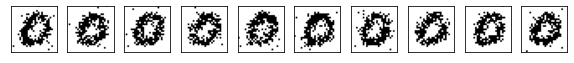

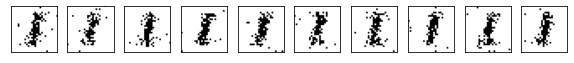

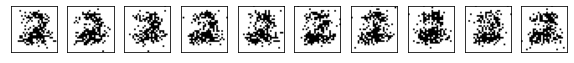

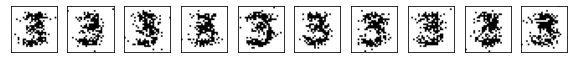

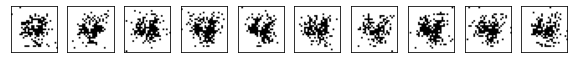

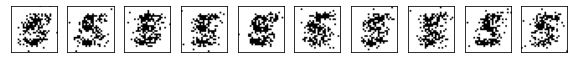

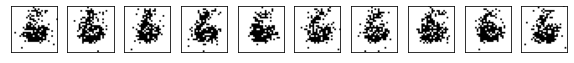

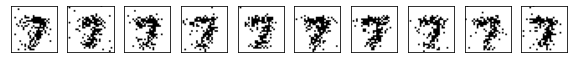

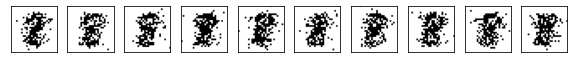

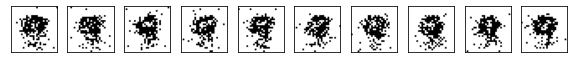

In [37]:
def Q5(num_examples):

  ### STUDENT START ###

  # The plot_digit function plots a 10x10 grid of digits
  # automatically generated by the model. 
  def plot_digit(x, i, j, figure):
    array = x.reshape(28,28)
    figure.add_subplot(10, 10, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(array, cmap = plt.cm.gray_r)

  # Code provided by Clarence.  
  def generate(log_probs):
    n = log_probs.shape[0]
    r = np.random.rand(n)
    d = np.zeros(n)
    for i in range(n):
      if r[i] < np.exp(log_probs[i]): d[i] = 1
    return d

  # Produces a Bernoulli Naive Bayes model using the 
  # mini_train_data dataset. The model is then used to 
  # automatically generate 10 examples of each digit.
  bnb_model = BernoulliNB()
  bnb_model.fit(mini_train_data, mini_train_labels)
  for i in range(num_examples):
    figure = plt.figure(figsize = (10,10))
    for j in range(num_examples):
      x = generate(bnb_model.feature_log_prob_[i])
      plot_digit(x, i, j, figure)

  ### STUDENT END ###

Q5(10)

**ANSWER:** The auto-generated digits are pixelated and are not as clear as the digits from the original dataset. We expected this as the generative model uses probabilities in order to determine if a pixel should be 0 or 1 (white or black). The probabilities are calculated across all instances of a digit from the training data, which also contains a variety of ways the same digit can be written - hence, the shape of the auto-generated digits are also somewhat difficult to recognize (i.e. the 8 in the column is hardly recognizable). Said differently, if the model was trained on the same handwritten digit (i.e. 1000 copies of the same hand written 8), the auto-generated image would not look pixelated and would look exactly like the version from the training data.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



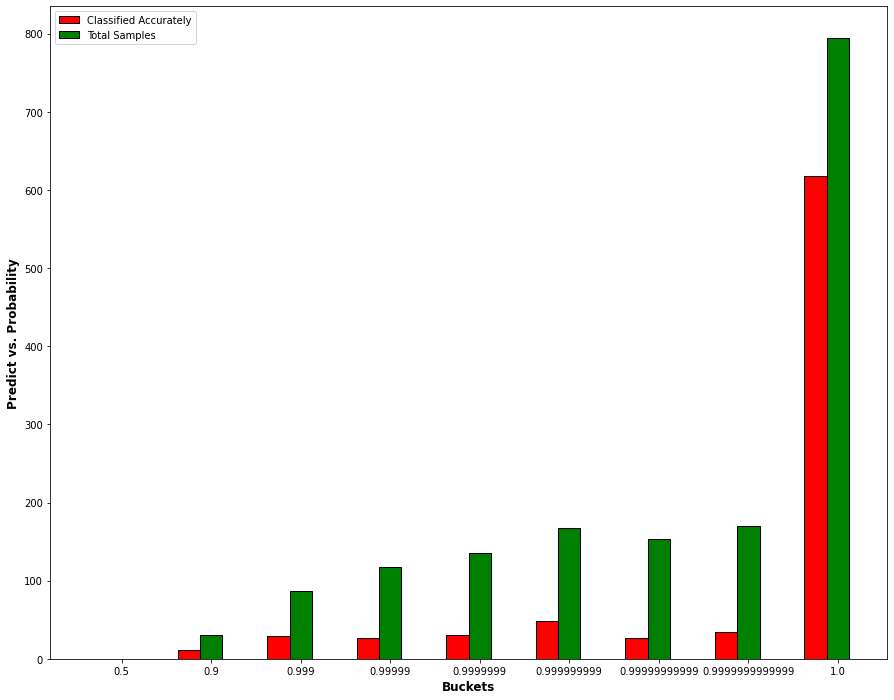

[0, 11, 29, 27, 30, 48, 26, 34, 618]
[0, 31, 87, 117, 136, 168, 153, 170, 795]


In [38]:
def Q6(buckets, correct, total):

  ### STUDENT START ###

  # The plot_bar_chart function plots a bar chart that displays the pre-defined
  # buckets, the total samples and times model classified digit accurately. 
  def plot_bar_chart(x_list, y_list1, y_list2):

    bar_width = 0.25
    fig = plt.subplots(figsize = (15, 12))
    bar1 = np.arange(len(x_list))
    bar2 = [x + bar_width for x in bar1]
    plt.bar(bar1, y_list1, color = 'r', width = bar_width, edgecolor = 'black', label = 'Classified Accurately')
    plt.bar(bar2, y_list2, color = 'g', width = bar_width, edgecolor = 'black', label = 'Total Samples')
  
    plt.xlabel('Buckets', fontweight = 'bold', fontsize = 12)
    plt.ylabel('Predict vs. Probability', fontweight = 'bold', fontsize = 12)
    plt.xticks([i + bar_width for i in range(len(x_list))], x_list)
    plt.legend()
    plt.show()

  # Trains a Bernoulli Naive Bayes model using the mini_train_data
  # dataset and make predictions on the dev_data dataset. The probabilities
  # of the models predictions are calculated in order to determine how 
  # confident the model was for each of its predictions. 
  bnb_model = BernoulliNB(alpha = 0.001) # Alpha from Q3.
  bnb_model.fit(mini_train_data, mini_train_labels)
  dev_pred = bnb_model.predict(dev_data)
  dev_data_predict_proba = bnb_model.predict_proba(dev_data)

  for i in range(len(dev_data)):
    actual_model_prediction = int(dev_pred[i])
    model_probability = dev_data_predict_proba[i][actual_model_prediction]
    actual_dev_label = int(dev_labels.iloc[i])

    for j in range(len(buckets)):
      if (model_probability <= buckets[j]):
        total[j] += 1
        if (actual_model_prediction == actual_dev_label):
          correct[j] +=1
          break
      
  plot_bar_chart(buckets, correct, total)
        
  ### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

print(correct)
print(total)

**ANSWER:** From previous questions, we observe the accuracy of a Naive Bayes model to be ~0.82. When examing the posterior probabilities of the model, we observe the model was 100% confident on 795 classifications. In reality, the model was only correct for 618 classifications, while 177 were incorrectly classified. We see a similar pattern across other pre-defined buckets, which leads us to a hypothesis that a Naive Bayes model is generally overally confident in its predictions. The results suggest the model is not strongly calibrated. 



### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [39]:
def Q7():

  ### STUDENT START ###

  # Uses a Naive Bayes algorithm with non-transformed training or dev 
  # (prediction) data, in order to produce a baseline accuracy score. 
  # The baseline accuracy is printed for comparision with a transformed
  # dataset performed in subsequent sections. 
  bnb_model = BernoulliNB(alpha = 0.001) # Using Alpha from previous question.
  bnb_model.fit(mini_train_data, mini_train_labels)
  print("Baseline Accuracy: ", bnb_model.score(dev_data, dev_labels))

  # Iterates through the mini_training_data dataset, then sorts the 
  # values (digits) in decending order. This transformation helps
  # the next stanza create a dictionary of how many instances of each 
  # digit exist in the dataset (i.e. there are 87 1s in dataset).
  my_list = list()
  for i in range(mini_train_labels.shape[0]):
    my_list.append(mini_train_labels.iloc[i])
  mini_train_data3 = mini_train_data.assign(my_label = my_list);
  df5 = mini_train_data3.sort_values(by = "my_label", ascending = False)

  # Creates a dictionary with digits (0-9) as the key and number of 
  # instances of that digit (i.e. 87 instances) as the value. This 
  # dictionary data structure enables an average calculation to be
  # performed on all 784 pixels for all buckets of digits (0-9). 
  my_cnt_list = dict()
  my_object_list = ['0','1','2','3','4','5','6','7','8','9']
  my_cnt = 0
  for i in range(len(my_object_list)):
    my_cnt_list[my_object_list[i]] = 0
  for row in range(df5.shape[0]):
    my_cnt_list[df5.iloc[row].values[784]] += 1
  
  # Calculates the average pixel value for each of the 784 columns for all 
  # instances of the digit '0' in the mini_train_data dataset. The results
  # are appended to the overall mini_train_data dataset (i.e. size 1000)
  # and is used as another feature for the Naive Bayes model. 
  col_index = 0
  col_784 = []
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['0']): # Calculates average for digit '0'.
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df3 = pd.DataFrame(hack_list)
  new_df4 = pd.concat([mini_train_data,new_df3],axis=0,join="outer",ignore_index=False,
                      keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  
  # Implements the same logic as above, but for the digit '1'.
  # The results are appended to the overall mini_train_data dataset
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['1']): # Calculates average for digit '1'.
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df5 = pd.DataFrame(hack_list)
  new_df6 = pd.concat([new_df4,new_df5],axis=0,join="outer",ignore_index=False,
                      keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '2'.
  # The results are appended to the overall mini_train_data dataset 
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['2']): # Calculates average for digit '2'.
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df7 = pd.DataFrame(hack_list)
  new_df8 = pd.concat([new_df6,new_df7],axis=0,join="outer",ignore_index=False,
                      keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '3'.
  # The results are appended to the overall mini_train_data dataset 
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['3']): # Calculates average for digit '3'.
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df9 = pd.DataFrame(hack_list)
  new_df10 = pd.concat([new_df8,new_df9],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '4'.
  # The results are appended to the overall mini_train_data dataset
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['4']): # Calculates average for digit '4'.
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df11 = pd.DataFrame(hack_list)
  new_df12 = pd.concat([new_df10,new_df11],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '5'.
  # The results are appended to the overall mini_train_data dataset 
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['5']): # Calculates average for digit '5'. 
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df13 = pd.DataFrame(hack_list)
  new_df14 = pd.concat([new_df12,new_df13],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '6'.
  # The results are appended to the overall mini_train_data dataset 
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['6']): # Calculates average for digit '6'. 
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave+= df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])

  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df15 = pd.DataFrame(hack_list)
  new_df16 = pd.concat([new_df14,new_df15],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '1'.
  # The results are appended to the overall mini_train_data dataset 
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['7']): # Calculates average for digit '7'.
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df17 = pd.DataFrame(hack_list)
  new_df18 = pd.concat([new_df16,new_df17],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '8'.
  # The results are appended to the overall mini_train_data dataset
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['8']): # Calculates average for digit '8'. 
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df19 = pd.DataFrame(hack_list)
  new_df20 = pd.concat([new_df18,new_df19],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Implements the same logic as above, but for the digit '9'.
  # The results are appended to the overall mini_train_data dataset
  # and is used as another feature for the Naive Bayes model. 
  ave = 0
  dict_of_cols = dict()
  label_list = list()
  for i in range(1, 785):
    label_list.append(str('pixel') + str(i))
    dict_of_cols[label_list[i-1]] = 0.0
  for keys in (['9']): # Calculates average for digit '9
    for col in range(784):
      ave = 0
      for row in range(my_cnt_list[keys]):
        ave += df5.iloc[row].values[col]
      dict_of_cols[label_list[col]] = (ave / my_cnt_list[keys])
  
  hack_list = list()
  hack_list.append(dict_of_cols)
  new_df21 = pd.DataFrame(hack_list)
  new_df22 = pd.concat([new_df20,new_df21],axis=0,join="outer",ignore_index=False,
                       keys=None,levels=None,names=None,verify_integrity=False,copy=True)

  # Concatenates each digit (0-9) to the labels dataset so that the Naive
  # Bayes model can fit a model with an equivalent sized dataset.
  new_y_label_df0 = pd.concat([mini_train_labels,pd.Series(['0'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df1 = pd.concat([new_y_label_df0,pd.Series(['1'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df2 = pd.concat([new_y_label_df1,pd.Series(['2'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df3 = pd.concat([new_y_label_df2,pd.Series(['3'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)  
  new_y_label_df4 = pd.concat([new_y_label_df3,pd.Series(['4'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df5 = pd.concat([new_y_label_df4,pd.Series(['5'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df6 = pd.concat([new_y_label_df5,pd.Series(['6'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df7 = pd.concat([new_y_label_df6,pd.Series(['7'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True) 
  new_y_label_df8 = pd.concat([new_y_label_df7,pd.Series(['8'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)
  new_y_label_df9 = pd.concat([new_y_label_df8,pd.Series(['9'])],axis=0,join="outer",ignore_index=False,keys=None,levels=None,names=None,verify_integrity=False,copy=True)    

  # Uses a Naive Bayes algorithm and transformed training data to make
  # predictions on dev_data dataset. The accuracy of the model is printed
  # for comparisons with a non-transformed training dataset performed
  # in the sections above.
  bnb_model = BernoulliNB(alpha = 0.001)
  bnb_model.fit(new_df22, new_y_label_df9)
  print("Improved Accuracy: ", bnb_model.score(dev_data, dev_labels))

### STUDENT END ###

Q7()

Baseline Accuracy:  0.823
Improved Accuracy:  0.817


**SUMMARY:** We approached this problem through the lens of adding a feature that would improve the model's accuracy from a baseline of 0.823. We concluded that averaging the pixel values of each column, was a reasonable approach because the resulting feature would be a more generalized version of the digit - and a more generalized digit could handle the multitude of ways a digit can be written. We implemented the vertical averaging transformation and was surprised to see the accuracy decreased to 0.817. Though not too far away from the baseline accuracy score, the decrease in accuracy might be explained through the analogy of the auto-generated digits in Q5. The auto-generated images somewhat resembled the digit, however, was based on average probabilities calcualted over a large training dataset with lots of different versions of a digit - hence, the image is distorted and not as helpful for the model. We also tried summing and averaging pixel rows and observed lower accuracy scores than vertical averaging. 

# Citations and Resources:

1.   Collaborated with Satya Srinivas and CB Bangalore.
2.   https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
3.   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
4.   https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
5.   https://stackoverflow.com/questions/44479790/gridsearchcv-initialization
6.   https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
7.   https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece
8.   https://medium.com/@akumar5/computer-vision-gaussian-filter-from-scratch-b485837b6e09
9.   https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c 
10.  https://pandas.pydata.org/docs/user_guide/merging.html
11.  https://datacarpentry.org/image-processing/06-blurring/ 
12.  https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece#:~:text=Laplace%20smoothing%20is%20a%20smoothing%20technique%20that%20helps%20tackle%20the,the%20positive%20and%20negative%20reviews. 


